In [ ]:
!pip install -U langgraph langchain langchain-openai
!apt-get -qq install -y graphviz libgraphviz-dev
!pip install -q pygraphviz

Let us import necessary libraries

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict


LangGraph is a flowchart for AI agents — you connect nodes (agents/tools), and the graph manages state & flow.
For example, let us create an agentic workflow for Pizza order delivery

We will Define "State" which is the Class for our Agentic Flow. Nodes are the "hubs" or "centers" that carry on single task. Edges are connections between these "hubs"

In [ ]:

class PizzaState(TypedDict):
    order: str
    confirmed: bool

Create Nodes

Node 1: Take order.

Node 2: Confirm order.

Node 3: Finalize order.

In [ ]:
def take_order(state: PizzaState):
    print("Bot: Hi! What pizza do you want?")
    choice = input("You: ")
    state["order"] = choice
    return state

def confirm_order(state: PizzaState):
    print(f"Bot: You want a {state['order']} pizza, right?")
    confirmation = input("Confirm (yes/no): ")
    state["confirmed"] = confirmation.lower() == "yes"
    return state

def finalize_order(state: PizzaState):
    if state["confirmed"]:
        print(f"Bot: Great! Your {state['order']} pizza is on the way!")
    else:
        print("Bot:Oops order was not confirmed")
    return state

Build Graph

In [ ]:

workflow = StateGraph(PizzaState)

workflow.add_node("take_order", take_order)
workflow.add_node("confirm_order", confirm_order)
workflow.add_node("finalize_order", finalize_order)

workflow.set_entry_point("take_order")

workflow.add_edge("take_order", "confirm_order")
workflow.add_edge("confirm_order", "finalize_order")

graph = workflow.compile()

Visualize the graph

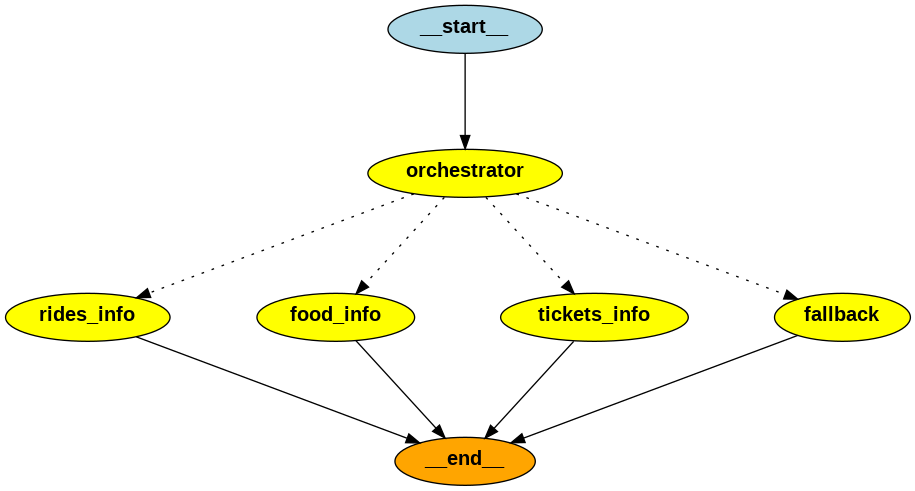

In [ ]:
from IPython.display import Image

# For Pizza workflow
graph_image = graph.get_graph().draw_png()
Image(graph_image)

Run the flow- try to test various output flows
1) Correct pizza name, respond yes for order confirmation
2) Wrong pizza name, respond no for order confirmation

In [ ]:
graph.invoke({"order": "", "confirmed": False})

Let us understand conditional edges.
Conditional edges are used to execure a node/hub based on a condition or an output of prior node/hub being a certain value. For example, The output of your last node confirming the order can be True or False. You can take different steps after this output based on the values True/False. If the order is not confirmed (False), you can restart the order process and if the order is confirmed (True) you can end the process.

In [ ]:
def take_order(state: PizzaState):
    print("Bot: Hi! What pizza do you want?")
    choice = input("You: ")
    state["order"] = choice
    return state

def confirm_order(state: PizzaState):
    print(f"Bot: You want a {state['order']} pizza, right?")
    confirmation = input("Confirm (yes/no): ")
    state["confirmed"] = confirmation.lower() == "yes"
    return state

def finalize_order(state: PizzaState):
    print(f"Bot: Great! Your {state['order']} pizza is on the way!")
    return state

In [ ]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(PizzaState)

workflow.add_node("take_order", take_order)
workflow.add_node("confirm_order", confirm_order)
workflow.add_node("finalize_order", finalize_order)

workflow.set_entry_point("take_order")

# Normal edge from taking order → confirmation
workflow.add_edge("take_order", "confirm_order")

# Conditional edges from confirmation
def decide_next(state: PizzaState):
    if state["confirmed"]:
        return "finalize_order"
    else:
        return "take_order"   # loop back if not confirmed

workflow.add_conditional_edges(
    "confirm_order",
    decide_next,   # function that decides next node
    {"finalize_order": "finalize_order", "take_order": "take_order"}
)

graph = workflow.compile()

In [ ]:
from IPython.display import Image

# Visualize
graph_image = graph.get_graph().draw_png()
Image(graph_image)

In [ ]:
# Run the graph
graph.invoke({"order": "", "confirmed": False})


Let us try a bit more complex example with a smart orchestrator that understands your query and routes it to appropriate department. Imagine you are in an amusement park and you go to the information desk. Based on the topic of your query, appropriate node/department is chosen to answer it.

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from transformers import pipeline
import random

# Simple free LLM (distil GPT-2-ish model for fun text gen)
generator = pipeline("text-generation", model="distilgpt2")

class ParkState(TypedDict):
    query: str
    answer: str
    selected_node: str

In [ ]:
# Orchestrator decides which node to go to
# Orchestrator updates state with the routing decision
def orchestrator(state: ParkState):
    q = state["query"].lower()
    if "ride" in q:
        state["selected_node"] = "rides_info"
    elif "food" in q or "eat" in q:
        state["selected_node"] = "food_info"
    elif "ticket" in q or "price" in q:
        state["selected_node"] = "tickets_info"
    else:
        state["selected_node"] = "fallback"
    return state

def rides_info(state: ParkState):
    rides = ["Roller Coaster", "Haunted Mansion", "Ferris Wheel"]
    state["answer"] = f"Our park has amazing rides like {random.choice(rides)}!"
    return state

def food_info(state: ParkState):
    foods = ["pizza", "hot dogs", "ice cream", "milkshakes"]
    state["answer"] = f"You’ll love our food court! We serve {random.choice(foods)}."
    return state

def tickets_info(state: ParkState):
    state["answer"] = "Tickets are $20 for kids and $35 for adults."
    return state

def fallback(state: ParkState):
    # Use a small free LLM to make up something fun
    gen = generator(f"The user asked: {state['query']}. Respond playfully:", max_length=40, num_return_sequences=1)
    state["answer"] = gen[0]["generated_text"]
    return state


In [ ]:
workflow = StateGraph(ParkState)

# Add nodes
workflow.add_node("orchestrator", orchestrator)
workflow.add_node("rides_info", rides_info)
workflow.add_node("food_info", food_info)
workflow.add_node("tickets_info", tickets_info)
workflow.add_node("fallback", fallback)

# Entry point is orchestrator
workflow.set_entry_point("orchestrator")

# Conditional routing
workflow.add_conditional_edges(
    "orchestrator",
    lambda state: state["selected_node"],
    {
        "rides_info": "rides_info",
        "food_info": "food_info",
        "tickets_info": "tickets_info",
        "fallback": "fallback",
    }
)

# All info nodes end workflow
workflow.add_edge("rides_info", END)
workflow.add_edge("food_info", END)
workflow.add_edge("tickets_info", END)
workflow.add_edge("fallback", END)

graph = workflow.compile()


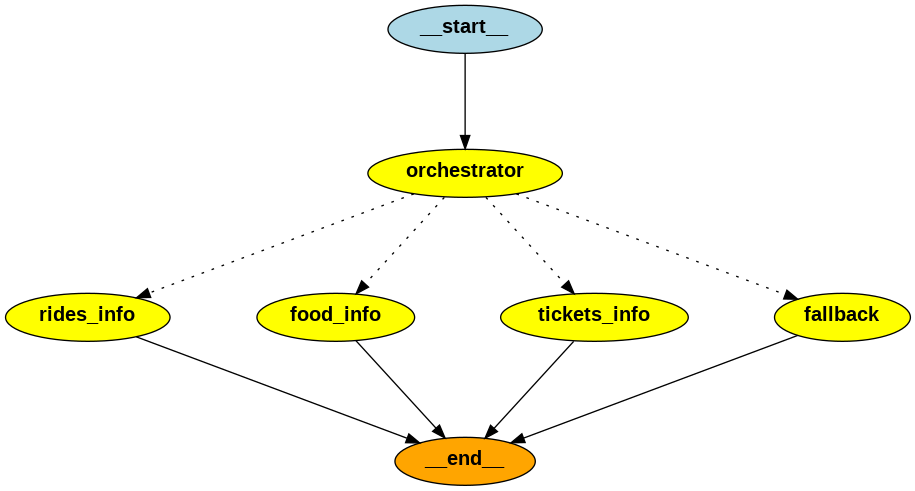

In [ ]:
from IPython.display import Image

graph_image = graph.get_graph().draw_png()
Image(graph_image)

In [ ]:
# Try different queries!
queries = [
    "What rides do you have?",
    "Where can I eat?",
    "How much are the tickets?",
]

for q in queries:
    print("\n User:", q)
    result = graph.invoke({"query": q, "answer": ""})
    print("Bot:", result["answer"])
